# Introduction to Challenges in ML Deployment

## Installation and Imports

In [2]:
print('Installing TensorFlow Data Validation')
!pip install --upgrade 'tensorflow_data_validation[visualization]<2'

Installing TensorFlow Data Validation


In [3]:
!pip install -U scikit-multiflow

In [4]:
import numpy as np
import pandas as pd
import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
import seaborn as sns

## Input Data Challenges: Drift and Skew

### Tensorflow Data Validation

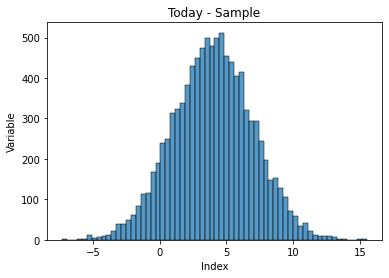

In [5]:
#Source: Modified from https://stackoverflow.com/questions/64854774/tfx-tensorflow-data-validation-tfdv-does-not-work-on-data-drift

# -------- Today --------

df = pd.DataFrame({
    'x1': np.random.normal(4, 3, 10000),
    'x2': np.random.normal(-3, 4, 10000)})
stats_train_today = tfdv.generate_statistics_from_dataframe(df)
ax = sns.histplot(data=df['x1'])
ax.set(xlabel="Index",
       ylabel="Variable",
       title="Today - Sample")
plt.show()

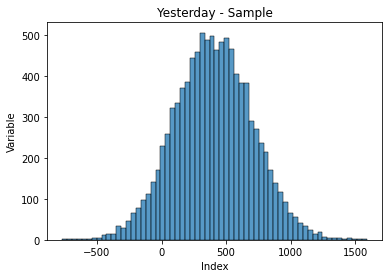

In [6]:
#Source: Modified from https://stackoverflow.com/questions/64854774/tfx-tensorflow-data-validation-tfdv-does-not-work-on-data-drift

# -------- Yesterday --------
df = pd.DataFrame({
    'x1': np.random.normal(400, 300, 10000),
    'x2': np.random.normal(-3, 4, 10000)})

stats_train_yesterday = tfdv.generate_statistics_from_dataframe(df)

ax = sns.histplot(data=df['x1'])

ax.set(xlabel="Index",
       ylabel="Variable",
       title="Yesterday - Sample")

plt.show()

In [7]:
#Source: Modified from https://stackoverflow.com/questions/64854774/tfx-tensorflow-data-validation-tfdv-does-not-work-on-data-drift

# -------- Validate --------

schema = tfdv.infer_schema(stats_train_yesterday)

tfdv.get_feature(schema, 'x1').drift_comparator.jensen_shannon_divergence.threshold = 0.01

anomalies = tfdv.validate_statistics(statistics=stats_train_today,
                                     schema=schema,
                                     previous_statistics=stats_train_yesterday)

tfdv.display_anomalies(anomalies)

Anomaly short description                                                                                                                      Anomaly long description
Feature name                                                                                                                                                                                                                       
'x1'          High approximate Jensen-Shannon divergence between current and previous  The approximate Jensen-Shannon divergence between current and previous is 0.953055 (up to six significant digits), above the threshold 0.01.

In [8]:
print(schema)

feature {
  name: "x1"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  drift_comparator {
    jensen_shannon_divergence {
      threshold: 0.01
    }
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "x2"
  type: FLOAT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}



### Sklearn Multiflow

In [9]:
import numpy as np
from skmultiflow.drift_detection.adwin import ADWIN
adwin = ADWIN()
# Simulating a data stream as a normal distribution of 1's and 0's
data_stream = np.random.randint(2, size=200)
# Changing the data concept from index 999 to 2000
for i in range(99, 200):
    data_stream[i] = np.random.randint(4, high=8)
# Adding stream elements to ADWIN and verifying if drift occurred
for i in range(200):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 7 - at index: 127
Change detected in data: 7 - at index: 159
Change detected in data: 7 - at index: 191


In [10]:
df = pd.DataFrame(data_stream, columns=list('A'))
ax = sns.lineplot(data=df)

ax.set(xlabel="Index",
       ylabel="Variable",
       title="Sample")

plt.show()

## Catastrophic Forgetting

### Toy example

**Source: This toy example is sourced from https://deeplearning.neuromatch.io/tutorials/W3D4_ContinualLearning/student/W3D4_Tutorial1.html#elastic-weight-consolidation-ewc**

In [12]:
# Imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from catastrophic_forgetting_helper_utils import *

In [13]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [14]:
import tarfile, requests, os
from torchvision import transforms
from torchvision.datasets import MNIST

name = 'MNIST'
fname = name + '.tar.gz'
url = 'https://www.di.ens.fr/~lelarge/MNIST.tar.gz'

if not os.path.exists(name):
  print('\nDownloading and unpacking MNIST data. Please wait a moment...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  with tarfile.open(fname) as tar:
    tar.extractall('./')  # Specify which folder to extract to
  os.remove(fname)
  print('\nDownloading MNIST completed.')
else:
  print('MNIST has been already downloaded.')


# Load the Data
mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([transforms.ToTensor(), ]),
                    train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([transforms.ToTensor(), ]),
                   train=False)

In [15]:
class Net(nn.Module):
  """
  Simple MultiLayer CNN with following attributes and structure.
  nn.Conv2d(1, 10, kernel_size=5) # First Convolutional Layer
  nn.Conv2d(10, 20, kernel_size=5) # Second Convolutional Layer [add dropout]
  nn.Linear(320, 50) # First Fully Connected Layer
  nn.Linear(50, 10) # Second Fully Connected Layer
  """

  def __init__(self):
    """
    Initialize Multilayer CNN parameters

    Args:
      None

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    """
    Forward pass of network

    Args:
      x: np.ndarray
        Input data

    Returns:
      x: np.ndarray
        Output from final fully connected layer
    """
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return x

In [16]:
def train(model, x_train, t_train, optimizer, epoch, device):
  """
  Train function

  Args:
    model: Net() type
      Instance of the multilayer CNN
    x_train: np.ndarray
      Training data
    t_train: np.ndarray
      Labels corresponding to the training data
    optimizer: torch.optim type
      Implements Adam algorithm.
    epoch: int
      Number of epochs
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  model.train()

  for start in range(0, len(t_train)-1, 256):
    end = start + 256
    x = torch.from_numpy(x_train[start:end])
    if torch.cuda.is_available():
      x = x.type(torch.cuda.FloatTensor)
    else:
      x = x.type(torch.FloatTensor)
    y = torch.from_numpy(t_train[start:end]).long()
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()

    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()
    optimizer.step()
  print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


# @markdown `test(model, x_test, t_test, device)`
def test(model, x_test, t_test, device):
    """
    Test function.

    Args:
      model: Net() type
        Instance of the multilayer CNN
      x_test: np.ndarray
        Test data
      t_test: np.ndarray
        Labels corresponding to the test data
      device: string
        CUDA/GPU if available, CPU otherwise

    Returns:
      Nothing
    """
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x = torch.from_numpy(x_test[start:end])
        if torch.cuda.is_available():
          x = x.type(torch.cuda.FloatTensor)
        else:
          x = x.type(torch.FloatTensor)
        y = torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item()  # Sum up batch loss
        pred = output.max(1, keepdim=True)[1]  # Get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

x_train dim: (60000, 1, 28, 28) and type: uint8
t_train dim: (60000,) and type: int64
x_train dim: (10000, 1, 28, 28) and type: uint8
t_train dim: (10000,) and type: int64

Task 1: MNIST Training data:



Task 2: Permuted MNIST data:


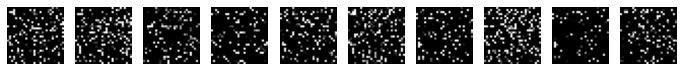

In [17]:
# Load in MNIST and create an additional permuted dataset
x_train, t_train, x_test, t_test = load_mnist(mnist_train, mnist_test,
                                              verbose=True)
x_train2, x_test2 = permute_mnist([x_train, x_test], 0, verbose=False)

# Plot the data to see what we're working with
print('\nTask 1: MNIST Training data:')
plot_mnist(x_train, nPlots=10)
print('\nTask 2: Permuted MNIST data:')
plot_mnist(x_train2, nPlots=10)

In [18]:
# Define a new model and set params
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model on MNIST
nEpochs = 3
print(f"Training model on {nEpochs} epochs...")
for epoch in range(1, nEpochs+1):
  train(model, x_train, t_train, optimizer, epoch, device=DEVICE)
  test(model, x_test, t_test, device=DEVICE)

Training model on 3 epochs...
Train Epoch: 1 	Loss: 0.890918
Test set: Average loss: 0.0003, Accuracy: 8415/10000 (84%)

Train Epoch: 2 	Loss: 0.688304
Test set: Average loss: 0.0002, Accuracy: 9277/10000 (93%)

Train Epoch: 3 	Loss: 0.947034
Test set: Average loss: 0.0001, Accuracy: 9370/10000 (94%)



Testing on task 1
Test set: Average loss: 0.0001, Accuracy: 9370/10000 (94%)

Testing on task 2
Test set: Average loss: 0.0020, Accuracy: 879/10000 (9%)



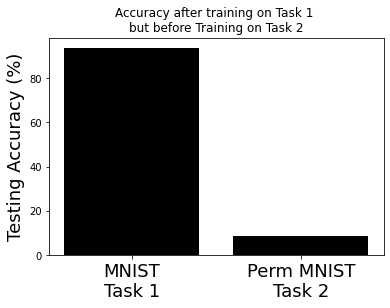

In [19]:
# Test the model's accuracy on both the regular and permuted dataset

# Let's define a dictionary that holds each of the task
# datasets and labels
tasks = {'MNIST':(x_test, t_test),
         'Perm MNIST':(x_test2, t_test)}
t1_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti + 1}")
  t1_accs.append(test(model, tasks[task][0], tasks[task][1], device=DEVICE))

# And then let's plot the testing accuracy on both datasets
multi_task_barplot(t1_accs, tasks, t='Accuracy after training on Task 1 \nbut before Training on Task 2')

Train Epoch: 1 	Loss: 1.990703
Test set: Average loss: 0.0008, Accuracy: 5925/10000 (59%)

Train Epoch: 2 	Loss: 1.741272
Test set: Average loss: 0.0006, Accuracy: 6694/10000 (67%)

Testing on task 1
Test set: Average loss: 0.0020, Accuracy: 942/10000 (9%)

Testing on task 2
Test set: Average loss: 0.0006, Accuracy: 6694/10000 (67%)



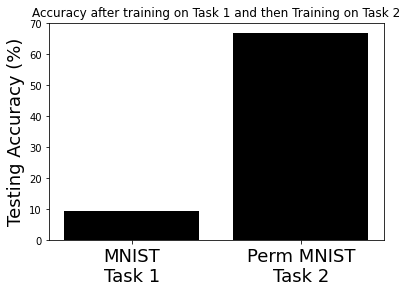

In [20]:
# Train the previously trained model on Task 2, the permuted MNIST dataset
for epoch in range(1, 3):
  train(model, x_train2, t_train, optimizer, epoch, device=DEVICE)
  test(model, x_test2, t_test, device=DEVICE)

# Same data as before, stored in a dict
tasks = {'MNIST':(x_test, t_test),
         'Perm MNIST':(x_test2, t_test)}
# Test the model on both datasets, same as before
t12_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti + 1}")
  t12_accs.append(test(model, tasks[task][0], tasks[task][1], device=DEVICE))

# And then let's plot each of the testing accuracies after the new training
multi_task_barplot(t12_accs, tasks, t='Accuracy after training on Task 1 and then Training on Task 2')

### Avalanche

In [21]:
!pip install avalanche-lib

     |████████████████████████████████| 425 kB 5.1 MB/s 
     |████████████████████████████████| 121 kB 34.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 532 kB 55.1 MB/s 
     |████████████████████████████████| 1.7 MB 40.4 MB/s 
     |████████████████████████████████| 181 kB 50.8 MB/s 
     |████████████████████████████████| 144 kB 65.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=f478b2b5c18c5440999b796de4a5ff562f50970ef055e837edb406ee4d64d714
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
  Created wheel for quadprog: filename=quadprog-0.1.11-cp37-cp37m-linux_x86_64.whl size=290743 sha256=3d74a462f5c3d24dc2d12a7f1c102c18a01b6b57731a186c7c849bfe4a051059
  Stored in directory: /root/.cache/pip/wheels/4

In [22]:
#Source: https://avalanche.continualai.org/getting-started/learn-avalanche-in-5-minutes

from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, \
    loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.strategies import Naive

scenario = SplitMNIST(n_experiences=5)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes)

# DEFINE THE EVALUATION PLUGIN and LOGGERS
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('log.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=scenario.n_classes, save_image=False,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.avalanche/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.avalanche/data/mnist/MNIST/raw

Starting experiment...
Start of experience:  0
Current Classes:  [9, 7]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --


/usr/local/lib/python3.7/dist-packages/avalanche/training/plugins/evaluation.py:85: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  "No benchmark provided to the evaluation plugin. "


100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 174676.8076
	DiskUsage_MB/train_phase/train_stream/Task000 = 174676.8076
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1813
	Loss_MB/train_phase/train_stream/Task000 = 0.5099
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0212
	Time_Epoch/train_phase/train_stream/Task000 = 8.7752
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6126
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8411
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 21/21 [00:01<00:00, 11.20it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 61.1822
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 174681.3945
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4523
	